In [1]:
import numpy as np
import xarray as xr
from matplotlib import pyplot as plt
plt.rcParams['figure.facecolor'] = 'white'
%config InlineBackend.print_figure_kwargs = {'bbox_inches': None}
import json
from scipy.optimize import curve_fit

In [2]:
path = "../data_for_plots/" 

In [4]:
with open(path + '/table_of_fluxes.annual_mean.json', 'r', encoding='utf-8') as f: 
    tof = json.load(f)
f.close()

In [5]:
MLD = xr.open_mfdataset(path + "MXLDEPTH_0201-01-01_0300-12-30_JJA_zonal_mean.nc").MXLDEPTH
T = xr.open_mfdataset(path + "THETA_0201-01-01_0300-12-30_JJA_zonal_mean.nc").THETA

In [6]:
SIarea = xr.open_mfdataset(path + "SIarea_0201-01-01_0300-12-30_JJA_zonal_mean.nc")
SIheff = xr.open_mfdataset(path + "SIheff_0201-01-01_0300-12-30_JJA_zonal_mean.nc")

In [7]:
SIedge15 = len(SIarea.YC) - SIarea.SIarea.where(SIarea.SIarea <= 0.15, other=1)[::-1].argmax("YC").values
SIedge80 = len(SIarea.YC) - SIarea.SIarea.where(SIarea.SIarea <= 0.80, other=1)[::-1].argmax("YC").values

In [8]:
lat = T.YG.values
plotlat = np.hstack((lat - ((lat[1] - lat[0]) / 2.), lat[-1] + ((lat[1] - lat[0]) / 2.)))

In [9]:
def no_axes(ax):
    ax.spines.left.set_visible(False)
    ax.spines.right.set_visible(False)
    ax.spines.top.set_visible(False)
    ax.spines.bottom.set_visible(False)
    ax.set_yticks([])
    ax.set_xticks([])
    ax.patch.set_alpha(0)

In [10]:
def hbars(vals1, vals2, errs1, errs2, ax, bw):
    bar1 = ax.barh(np.arange(0, 3), vals1, xerr=None, align='center', 
                   color=["steelblue", "k", "yellowgreen"],
                   hatch=["|||", "", ""], height=bw)
    bar2 = ax.barh(0, vals2, xerr=None, left=vals1[0], align='center', 
                  color=["steelblue"],
                  hatch=[""], height=bw)
    no_axes(ax)
    return bar1, bar2

In [11]:
def hbars_deep(vals1, vals2, errs1, errs2, ax, bw):
    bar1 = ax.barh(np.arange(0, 2), vals1, xerr=None, align='center', 
                   color=["steelblue", "yellowgreen"],
                   hatch=["|||", ""], height=bw)
    bar2 = ax.barh(0, vals2, xerr=None, left=vals1[0], align='center', 
                  color=["steelblue"],
                  hatch=[""], height=bw)
    no_axes(ax)
    return bar1, bar2

In [12]:
def vbars(vals1, vals2, errs1, errs2, ax, bw):
    bar1 = ax.bar(np.arange(0, 3), vals1, yerr=None, align='center', 
                  color=["steelblue", "k", "yellowgreen"],
                  hatch=["---", "", ""], width=bw)
    bar2 = ax.bar(0, vals2, yerr=None, bottom=vals1[0], align='center', 
                  color=["steelblue"],
                  hatch=[""], width=bw)
    no_axes(ax)
    return bar1, bar2

In [13]:
def func(x, a, b, c, d, e, f, g):
    return a + b*x + c*(x**2) + d*(x**3) + e*(x**4) + f*(x**5) + g*(x**6)
MLDcoefs, MLDcov = curve_fit(func, T.YG.values[2::], MLD.values[2::])
MLDschema = func(T.YG.values[2::], *MLDcoefs)

def func2(x, a, b, c):
    return a + b*x + c*(x**2)
ICEcoefs, ICEcov = curve_fit(func2, SIheff.YC.values[2:180], SIheff.SIheff.values[2:180])
ICEschema = func2(SIheff.YC.values[2:180], *ICEcoefs)

/tmp/ipykernel_958835/3724371402.py:2: RuntimeWarning: overflow encountered in power
  return a + b*x + c*(x**2) + d*(x**3) + e*(x**4) + f*(x**5) + g*(x**6)


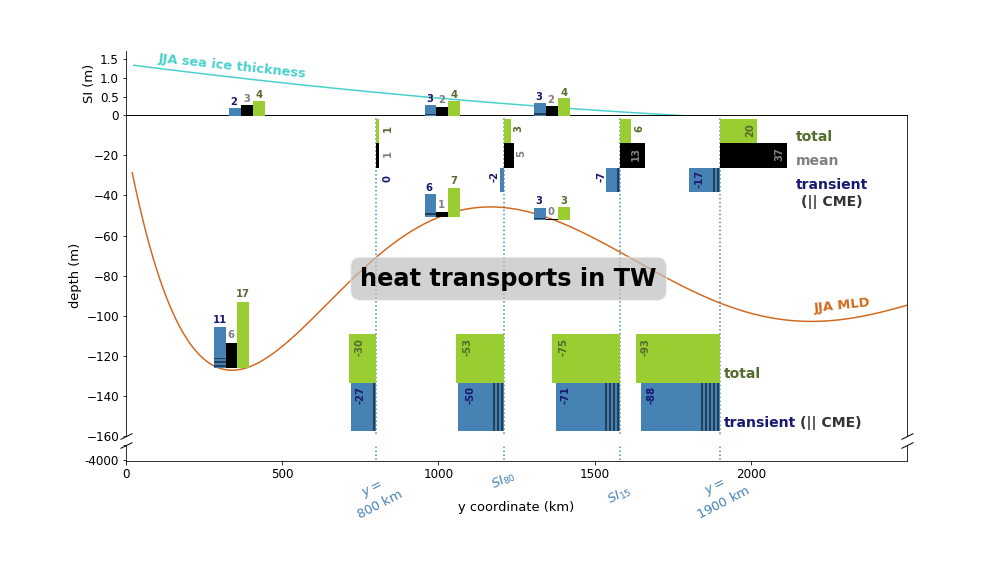

In [26]:
fig, (ax, ax2) = plt.subplots(2, 1, gridspec_kw={"height_ratios": [20, 1]}, sharex=True, figsize=(14, 8))
axice = ax.inset_axes([0, 1, 1, 0.2])
Dmax = 26

### plot temperature as background ###################################################################################
c = ax.plot(T.YG[2::], -MLDschema, color="chocolate")

######################################################################################################################

### set limits, labels, ticks on main plot ###########################################################################
ax.set_xlim(0, 2.5e6)
ax.set_ylim(-160, 0)
ax.set_yticks(np.arange(-160, 0.1, 20))
ax.set_ylabel("depth (m)", fontsize=13)
ax2.set_xlabel("y coordinate (km)", labelpad=20, fontsize=13)
ax.set_xticks(np.arange(0, 2.5e6, 0.5e6))
ax.set_xticklabels(np.arange(0, 2500, 500))

######################################################################################################################

### plot seaice on top on set limits, labels, ticks ##################################################################
b = axice.plot(SIheff.YC[2:180], ICEschema, color="mediumturquoise")
axice.set_xlim(0, 2.5e6)
axice.set_ylim(0.01, 1.7)
axice.set_xticks([])
axice.set_ylabel("SI (m)", fontsize=13)
axice.spines.right.set_visible(False)
axice.spines.top.set_visible(False)
plt.subplots_adjust(top=0.8)

######################################################################################################################

### plot the four latitudes that are used for the calculations #######################################################
ax.vlines(190 * 1e4, -420, 0, ls=":", color="steelblue", alpha=1)
ax.vlines(SIedge15 * 1e4, -420, 0, ls=":", color="steelblue", alpha=1)
ax.vlines(SIedge80 * 1e4, -420, 0, ls=":", color="steelblue", alpha=1)
ax.vlines(80 * 1e4, -420, 0, ls=":", color="steelblue", alpha=1)

######################################################################################################################


### create the broken y-axes #########################################################################################
ax.spines.bottom.set_visible(False)
ax2.spines.top.set_visible(False)
ax.xaxis.tick_top()

d = .5  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
ax.plot([0, 1], [0, 0], transform=ax.transAxes, **kwargs)
ax2.plot([0, 1], [1, 1], transform=ax2.transAxes, **kwargs)

ax2.set_yticks([0, 1])
ax2.set_yticklabels(["-4000", ""])

######################################################################################################################

### plot the latitudes in the lower axis and remove the redundant colorbar
ax2.vlines(190 * 1e4, 0, 1, ls=":", color="steelblue", alpha=1)
ax2.vlines(SIedge15 * 1e4, 0, 1, ls=":", color="steelblue", alpha=1)
ax2.vlines(SIedge80 * 1e4, 0, 1, ls=":", color="steelblue", alpha=1)
ax2.vlines(80 * 1e4, 0, 1, ls=":", color="steelblue", alpha=1)

ax2.text(190 * 1e4, -4, "$y=$\n$1900$ km", color="steelblue", ha="center", fontsize=13, rotation=27)
ax2.text(SIedge15 * 1e4, -3, "$SI_{15}$", color="steelblue", ha="center", fontsize=13, rotation=27)
ax2.text(SIedge80 * 1e4, -2, "$SI_{80}$", color="steelblue", ha="center", fontsize=13, rotation=27)
ax2.text(80 * 1e4, -4, "$y=$\n$800$ km", color="steelblue", ha="center", fontsize=13, rotation=27)

######################################################################################################################

######################################################################################################################
### BAR PLOTS ########################################################################################################
######################################################################################################################

### common paramters for all bar plots ###############################################################################
cats = np.arange(0, 4)
hbar_width = 0.3
hbar_height_up = 0.25
hbar_height_below = 0.5 * (2/3)
xmin = -93
xmax = 37
vbar_width = 0.05
vbar_height = 1.5
ymin = -93
ymax = 37

### horizontal bars in ML ############################################################################################

tmp = tof["horizontal HT within ML"]["at y=80"]
vals0a1 = np.array([tmp["CME_mean"], tmp["mean_mean"], tmp["total_mean"]])
vals0a2 = np.array([tmp["transient_mean"] - tmp["CME_mean"]])
errs0a1 = np.array([0, tmp["mean_std"], tmp["total_std"]])
errs0a2 = np.array([tmp["transient_std"]])
bar_ax0a = ax.inset_axes([0.105, 0.75, hbar_width, hbar_height_up])
bar0a = hbars(vals0a1, vals0a2, errs0a1, errs0a2, bar_ax0a, 1)
bar_ax0a.set_xlim(xmin, xmax)
bar_ax0a.text(4, 2.05, int(tmp["total_mean"]), fontweight="bold", color="darkolivegreen", rotation=90)
bar_ax0a.text(4, 1.0, int(tmp["mean_mean"]), fontweight="bold", color="gray", rotation=90)
bar_ax0a.text(4, -0., int(tmp["transient_mean"]), fontweight="bold", color="midnightblue", rotation=90)

tmp = tof["horizontal HT within ML"]["at 80% ice"]
vals1a1 = np.array([tmp["CME_mean"], tmp["mean_mean"], tmp["total_mean"]])
vals1a2 = np.array([tmp["transient_mean"] - tmp["CME_mean"]])
errs1a1 = np.array([0, tmp["mean_std"], tmp["total_std"]])
errs1a2 = np.array([tmp["transient_std"]])
bar_ax1a = ax.inset_axes([0.269, 0.75, hbar_width, hbar_height_up])
bar1a = hbars(vals1a1, vals1a2, errs1a1, errs1a2, bar_ax1a, 1)
bar_ax1a.set_xlim(xmin, xmax)
bar_ax1a.text(5, 2.05, int(tmp["total_mean"]), fontweight="bold", color="darkolivegreen", rotation=90)
bar_ax1a.text(7, 1.0, int(tmp["mean_mean"]), fontweight="bold", color="gray", rotation=90)
bar_ax1a.text(-8, -0., int(tmp["transient_mean"]), fontweight="bold", color="midnightblue", rotation=90)

tmp = tof["horizontal HT within ML"]["at 15% ice"]
vals2a1 = np.array([tmp["CME_mean"], tmp["mean_mean"], tmp["total_mean"]])
vals2a2 = np.array([tmp["transient_mean"] - tmp["CME_mean"]])
errs2a1 = np.array([0, tmp["mean_std"], tmp["total_std"]])
errs2a2 = np.array([tmp["transient_std"]])
bar_ax2a = ax.inset_axes([0.418, 0.75, hbar_width, hbar_height_up])
bar2a = hbars(vals2a1, vals2a2, errs2a1, errs2a2, bar_ax2a, 1)
bar_ax2a.set_xlim(xmin, xmax)
bar_ax2a.text(8, 2.05, int(tmp["total_mean"]), fontweight="bold", color="darkolivegreen", rotation=90)
bar_ax2a.text(6, 0.85, int(tmp["mean_mean"]), fontweight="bold", color="gray", rotation=90)
bar_ax2a.text(-13, -0., int(tmp["transient_mean"]), fontweight="bold", color="midnightblue", rotation=90)

tmp = tof["horizontal HT within ML"]["at y=190"]
vals3a1 = np.array([tmp["CME_mean"], tmp["mean_mean"], tmp["total_mean"]])
vals3a2 = np.array([tmp["transient_mean"] - tmp["CME_mean"]])
errs3a1 = np.array([0, tmp["mean_std"], tmp["total_std"]])
errs3a2 = np.array([tmp["transient_std"]])
bar_ax3a = ax.inset_axes([0.546, 0.75, hbar_width, hbar_height_up])
bar3a = hbars(vals3a1, vals3a2, errs3a1, errs3a2, bar_ax3a, 1)
bar_ax3a.set_xlim(xmin, xmax)
bar_ax3a.text(14, 1.85, int(tmp["total_mean"]), fontweight="bold", color="darkolivegreen", rotation=90)
bar_ax3a.text(30, 0.85, int(tmp["mean_mean"]), fontweight="bold", color="gray", rotation=90)
bar_ax3a.text(-14, -0.25, int(tmp["transient_mean"]), fontweight="bold", color="midnightblue", rotation=90)
bar_ax3a.text(42, 1.6, "total", fontweight="bold", color="darkolivegreen", fontsize=14)
bar_ax3a.text(42, 0.6, "mean", fontweight="bold", color="gray", fontsize=14)
bar_ax3a.text(42, -0.4, "transient", fontweight="bold", color="midnightblue", fontsize=14)
bar_ax3a.text(45, -1.1, "(|| CME)", fontweight="bold", color="k", fontsize=14, alpha=0.8)

######################################################################################################################

### horizontal bars below ML #########################################################################################

tmp = tof["horizontal HT below ML"]["at y=80"]
vals0b1 = np.array([tmp["CME_mean"], tmp["total_mean"]]) / 2.
vals0b2 = np.array([tmp["transient_mean"] - tmp["CME_mean"]]) / 2.
errs0b1 = np.array([0, tmp["total_std"]]) / 2.
errs0b2 = np.array([tmp["transient_std"]]) / 2.
bar_ax0b = ax.inset_axes([0.105, 0.0, hbar_width, hbar_height_below])
bar0b = hbars_deep(vals0b1, vals0b2, errs0b1, errs0b2, bar_ax0b, 1)
bar_ax0b.set_xlim(xmin, xmax)
bar_ax0b.text(-12, 1.1, int(tmp["total_mean"]), fontweight="bold", color="darkolivegreen", rotation=90)
bar_ax0b.text(-11, 0.1, int(tmp["transient_mean"]), fontweight="bold", color="midnightblue", rotation=90)

tmp = tof["horizontal HT below ML"]["at 80% ice"]
vals1b1 = np.array([tmp["CME_mean"], tmp["total_mean"]]) / 2.
vals1b2 = np.array([tmp["transient_mean"] - tmp["CME_mean"]]) / 2.
errs1b1 = np.array([0,  tmp["total_std"]]) / 2.
errs1b2 = np.array([tmp["transient_std"]]) / 2.
bar_ax1b = ax.inset_axes([0.269, 0.0, hbar_width, hbar_height_below])
bar1b = hbars_deep(vals1b1, vals1b2, errs1b1, errs1b2, bar_ax1b, 1)
bar_ax1b.set_xlim(xmin, xmax)
bar_ax1b.text(-23, 1.1, int(tmp["total_mean"]), fontweight="bold", color="darkolivegreen", rotation=90)
bar_ax1b.text(-21, 0.1, int(tmp["transient_mean"]), fontweight="bold", color="midnightblue", rotation=90)

tmp = tof["horizontal HT below ML"]["at 15% ice"]
vals2b1 = np.array([tmp["CME_mean"], tmp["total_mean"]]) / 2.
vals2b2 = np.array([tmp["transient_mean"] - tmp["CME_mean"]]) / 2.
errs2b1 = np.array([0, tmp["total_std"]]) / 2.
errs2b2 = np.array([tmp["transient_std"]]) / 2.
bar_ax2b = ax.inset_axes([0.418, 0.0, hbar_width, hbar_height_below])
bar2b = hbars_deep(vals2b1, vals2b2, errs2b1, errs2b2, bar_ax2b, 1)
bar_ax2b.set_xlim(xmin, xmax)
bar_ax2b.text(-34, 1.1, int(tmp["total_mean"]), fontweight="bold", color="darkolivegreen", rotation=90)
bar_ax2b.text(-33, 0.1, int(tmp["transient_mean"]), fontweight="bold", color="midnightblue", rotation=90)

tmp = tof["horizontal HT below ML"]["at y=190"]
vals3b1 = np.array([tmp["CME_mean"], tmp["total_mean"]]) / 2.
vals3b2 = np.array([tmp["transient_mean"] - tmp["CME_mean"]]) / 2.
errs3b1 = np.array([0, tmp["total_std"]]) / 2.
errs3b2 = np.array([tmp["transient_std"]]) / 2.
bar_ax3b = ax.inset_axes([0.546, 0.0, hbar_width, hbar_height_below])
bar3b = hbars_deep(vals3b1, vals3b2, errs3b1, errs3b2, bar_ax3b, 1)
bar_ax3b.set_xlim(xmin, xmax)
bar_ax3b.text(-44, 1.1, int(tmp["total_mean"]), fontweight="bold", color="darkolivegreen", rotation=90)
bar_ax3b.text(-41, 0.1, int(tmp["transient_mean"]), fontweight="bold", color="midnightblue", rotation=90)
bar_ax3b.text(2, 0.6, "total", fontweight="bold", color="darkolivegreen", fontsize=14)
bar_ax3b.text(2, -0.4, "transient", fontweight="bold", color="midnightblue", fontsize=14)
bar_ax3b.text(44, -0.4, "(|| CME)", fontweight="bold", color="k", fontsize=14, alpha=0.8)

######################################################################################################################

### vertical bars across ML base #####################################################################################

tmp = tof["vertical across base of ML"]["y=0 - y=80"]
vals0c1 = np.array([tmp["CME_mean"], tmp["mean_mean"], tmp["total_mean"]])
errs0c1 = np.array([0, tmp["mean_std"], tmp["total_std"]])
vals0c2 = np.array([tmp["transient_mean"] - tmp["CME_mean"]])
errs0c2 = np.array([tmp["transient_std"]])
bar_ax0c = ax.inset_axes([0.11, -0.86, vbar_width, vbar_height])
bar0c = vbars(vals0c1, vals0c2, errs0c1, errs0c2, bar_ax0c, 1)
bar_ax0c.set_ylim(ymin, ymax)
bar_ax0c.text(1.4, 19, int(tmp["total_mean"]), fontweight="bold", color="darkolivegreen")
bar_ax0c.text(0.65, 8., int(tmp["mean_mean"]), fontweight="bold", color="gray")
bar_ax0c.text(-0.6, 12., int(tmp["transient_mean"]), fontweight="bold", color="midnightblue")

tmp = tof["vertical across base of ML"]["y=80 - 80% sea ice"]
vals1c1 = np.array([tmp["CME_mean"], tmp["mean_mean"], tmp["total_mean"]])
errs1c1 = np.array([0, tmp["mean_std"], tmp["total_std"]])
vals1c2 = np.array([tmp["transient_mean"] - tmp["CME_mean"]])
errs1c2 = np.array([tmp["transient_std"]])
bar_ax1c = ax.inset_axes([0.38, -0.39, vbar_width, vbar_height])
bar1c = vbars(vals1c1, vals1c2, errs1c1, errs1c2, bar_ax1c, 1)
bar_ax1c.set_ylim(ymin, ymax)
bar_ax1c.text(1.7, 9, int(tmp["total_mean"]), fontweight="bold", color="darkolivegreen")
bar_ax1c.text(0.65, 2.5, int(tmp["mean_mean"]), fontweight="bold", color="gray")
bar_ax1c.text(-0.4, 7., int(tmp["transient_mean"]), fontweight="bold", color="midnightblue")

tmp = tof["vertical across base of ML"]["80% - 15% sea ice"]
vals2c1 = np.array([tmp["CME_mean"], tmp["mean_mean"], tmp["total_mean"]])
errs2c1 = np.array([0, tmp["mean_std"], tmp["total_std"]])
vals2c2 = np.array([tmp["transient_mean"] - tmp["CME_mean"]])
errs2c2 = np.array([tmp["transient_std"]])
bar_ax2c = ax.inset_axes([0.52, -0.4, vbar_width, vbar_height])
bar2c = vbars(vals2c1, vals2c2, errs2c1, errs2c2, bar_ax2c, 1)
bar_ax2c.set_ylim(ymin, ymax)
bar_ax2c.text(1.7, 4.5, int(tmp["total_mean"]), fontweight="bold", color="darkolivegreen")
bar_ax2c.text(0.65, 1.5, int(tmp["mean_mean"]), fontweight="bold", color="gray")
bar_ax2c.text(-0.4, 4.5, int(tmp["transient_mean"]), fontweight="bold", color="midnightblue")

######################################################################################################################

### vertical bars across ocean-ice interface #########################################################################
tmp = tof["vertical from ocean to ice"]["y=0 - y=80"]
vals0d1 = np.array([tmp["CME_mean"], tmp["mean_mean"], tmp["total_mean"]])
errs0d1 = np.array([0, tmp["mean_std"], tmp["total_std"]])
vals0d2 = np.array([tmp["transient_mean"] - tmp["CME_mean"]])
errs0d2 = np.array([tmp["transient_std"]])
bar_ax0d = ax.inset_axes([0.13, -0.077, vbar_width, vbar_height])
bar0d = vbars(vals0d1, vals0d2, errs0d1, errs0d2, bar_ax0d, 1)
bar_ax0d.set_ylim(ymin, ymax)
bar_ax0d.text(1.7, 5., int(tmp["total_mean"]), fontweight="bold", color="darkolivegreen")
bar_ax0d.text(0.65, 4, int(tmp["mean_mean"]), fontweight="bold", color="gray")
bar_ax0d.text(-0.4, 3, int(tmp["transient_mean"]), fontweight="bold", color="midnightblue")

tmp = tof["vertical from ocean to ice"]["y=80 - 80% sea ice"]
vals1d1 = np.array([tmp["CME_mean"], tmp["mean_mean"], tmp["total_mean"]])
errs1d1 = np.array([0, tmp["mean_std"], tmp["total_std"]])
vals1d2 = np.array([tmp["transient_mean"] - tmp["CME_mean"]])
errs1d2 = np.array([tmp["transient_std"]])
bar_ax1d = ax.inset_axes([0.38, -0.077, vbar_width, vbar_height])
bar1d = vbars(vals1d1, vals1d2, errs1d1, errs1d2, bar_ax1d, 1)
bar_ax1d.set_ylim(ymin, ymax)
bar_ax1d.text(1.7, 5., int(tmp["total_mean"]), fontweight="bold", color="darkolivegreen")
bar_ax1d.text(0.65, 3.5, int(tmp["mean_mean"]), fontweight="bold", color="gray")
bar_ax1d.text(-0.4, 4., int(tmp["transient_mean"]), fontweight="bold", color="midnightblue")

tmp = tof["vertical from ocean to ice"]["80% - 15% sea ice"]
vals2d1 = np.array([tmp["CME_mean"], tmp["mean_mean"], tmp["total_mean"]])
errs2d1 = np.array([0, tmp["mean_std"], tmp["total_std"]])
vals2d2 = np.array([tmp["transient_mean"] - tmp["CME_mean"]])
errs2d2 = np.array([tmp["transient_std"]])
bar_ax2d = ax.inset_axes([0.52, -0.077, vbar_width, vbar_height])
bar2d = vbars(vals2d1, vals2d2, errs2d1, errs2d2, bar_ax2d, 1)
bar_ax2d.set_ylim(ymin, ymax)
bar_ax2d.text(1.7, 5.5, int(tmp["total_mean"]), fontweight="bold", color="darkolivegreen")
bar_ax2d.text(0.65, 3.5, int(tmp["mean_mean"]), fontweight="bold", color="gray")
bar_ax2d.text(-0.4, 4.5, int(tmp["transient_mean"]), fontweight="bold", color="midnightblue")

######################################################################################################################


axice.text(0.1e6, 1.0, "JJA sea ice thickness", fontsize=13, color="mediumturquoise", rotation=-6, fontweight="bold")
axice.tick_params(axis='y', which='major', labelsize=12)
ax.text(2.2e6, -98, "JJA MLD", fontsize=13, color="chocolate", fontweight="bold", rotation=6)
ax.tick_params(axis='both', which='major', labelsize=12)
ax2.tick_params(axis='both', which='major', labelsize=12)
plt.subplots_adjust(bottom=0.2, hspace=0.05)

main_text = ax.text(0.75e6, -85, "heat transports in TW", color="k", fontsize=24, fontweight="bold")
main_text.set_bbox(dict(facecolor='silver', alpha=0.7, edgecolor='whitesmoke', boxstyle="round,pad=0.4"))

plt.savefig("fig09-schematic.png", dpi=300)